In [180]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
start_date = "2020-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

data = yf.download(stocks, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
print(data.tail())





[*********************100%***********************]  5 of 5 completed

Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA
Date                                                                  
2025-07-28  214.050003  232.789993  192.580002  512.500000  325.589996
2025-07-29  211.270004  231.009995  195.750000  512.570007  321.200012
2025-07-30  209.050003  230.190002  196.529999  513.239990  319.040009
2025-07-31  207.570007  234.110001  191.899994  533.500000  308.269989
2025-08-01  202.380005  214.750000  189.130005  524.109985  302.630005


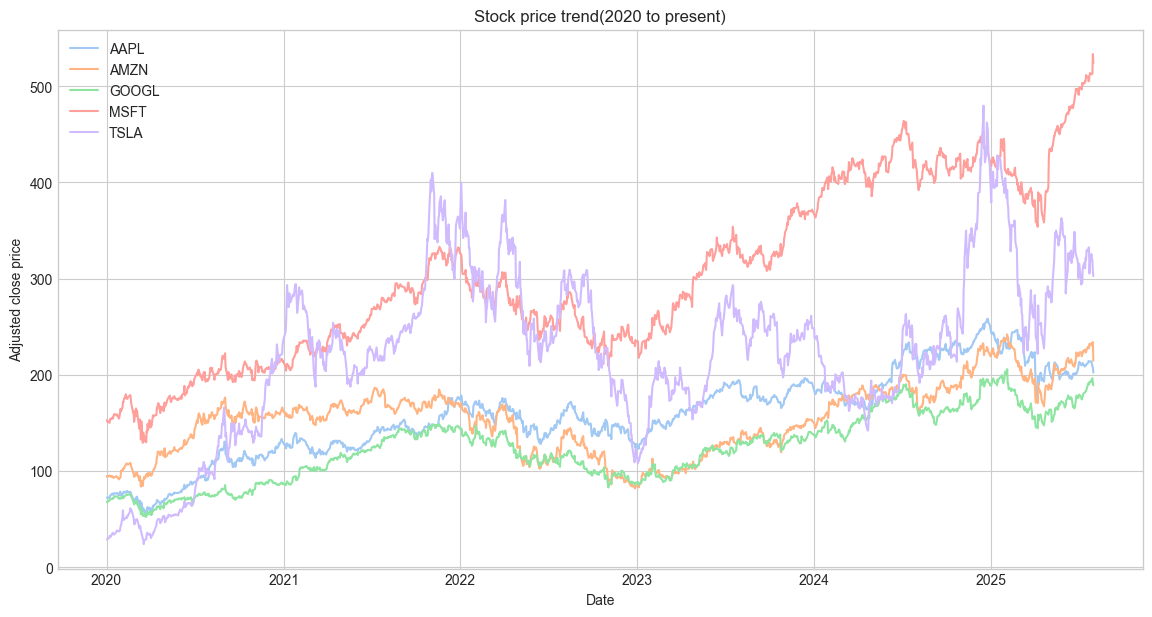

In [181]:
plt.figure(figsize=(14, 7))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)
plt.title("Stock price trend(2020 to present)")
plt.xlabel("Date")
plt.ylabel("Adjusted close price")
plt.legend()
plt.grid(True)
plt.show()

In [182]:
returns = data.pct_change().dropna()

print("\nFirst 5 rows of daily returns:")
print(returns.head())

mu = returns.mean() * 252  
cov_matrix = returns.cov() * 252   
print("\nAnnual average return (mu):")
print(mu)
print("\nAnnual covariance matrix (Sigma):")
print(cov_matrix)



First 5 rows of daily returns:
Ticker          AAPL      AMZN     GOOGL      MSFT      TSLA
Date                                                        
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452  0.029633
2020-01-06  0.007968  0.014886  0.026654  0.002585  0.019255
2020-01-07 -0.004703  0.002092 -0.001931 -0.009118  0.038801
2020-01-08  0.016086 -0.007809  0.007117  0.015929  0.049205
2020-01-09  0.021241  0.004799  0.010498  0.012493 -0.021945

Annual average return (mu):
Ticker
AAPL     0.236610
AMZN     0.211882
GOOGL    0.237138
MSFT     0.267055
TSLA     0.653247
dtype: float64

Annual covariance matrix (Sigma):
Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.105026  0.070314  0.067220  0.071299  0.109493
AMZN    0.070314  0.130289  0.076680  0.074463  0.110299
GOOGL   0.067220  0.076680  0.106505  0.071737  0.093433
MSFT    0.071299  0.074463  0.071737  0.091506  0.093058
TSLA    0.109493  0.110

In [187]:
n_assets = len(stocks)
equal_weights = np.ones(n_assets) / n_assets 
print("\nEqual Weights:")
for stock, weight in zip(stocks, equal_weights):
    print(f"{stock}: {weight:.4f} or {weight*100:.2f}%")

# Calculate and print the risk
equal_risk = np.sqrt(equal_weights @ cov_matrix @ equal_weights)
print(f"\nEqual Portfolio Risk: {equal_risk:.4f} or {equal_risk*100:.2f}% & Return: {np.sum(equal_weights * mu):.4f} or {np.sum(equal_weights * mu)*100:.2f}%")



Equal Weights:
AAPL: 0.2000 or 20.00%
GOOGL: 0.2000 or 20.00%
MSFT: 0.2000 or 20.00%
AMZN: 0.2000 or 20.00%
TSLA: 0.2000 or 20.00%

Equal Portfolio Risk: 0.3207 or 32.07% & Return: 0.3212 or 32.12%


In [188]:
def optimize_portfolio_newton(cov_matrix, max_iter=100, tol=1e-6):
    n = cov_matrix.shape[0]
    w0 = np.ones(n) / n  # Start with equal weights
    lambda0 = 0
    x0 = np.hstack([w0, lambda0])
    
    for _ in range(max_iter):
        w = x0[:-1]
        lam = x0[-1]
        
        # Gradient
        grad_w = 2 * cov_matrix @ w - lam * np.ones(n)
        grad_lam = 1 - np.sum(w)
        grad = np.hstack([grad_w, grad_lam])
        
        # Hessian
        H = np.vstack([
            np.hstack([2 * cov_matrix, -np.ones(n).reshape(-1, 1)]),
            np.hstack([-np.ones(n), 0])
        ])
        
        # Newton step
        delta_x = np.linalg.solve(H, -grad)
        x0 += delta_x
        
        if np.linalg.norm(delta_x) < tol:
            break
    
    weights = x0[:-1] / np.sum(x0[:-1])  # Normalize
    return weights

optimal_weights = optimize_portfolio_newton(cov_matrix.values)
optimal_risk = np.sqrt(optimal_weights @ cov_matrix @ optimal_weights)
print("\nOptimal Weight:")
for stock, weight in zip(stocks, optimal_weights):
 print(f"{stock}: {weight:.4f} or {weight*100:.2f}%")

print(f"\nOptimized Portfolio Risk: {optimal_risk*100:.2f}% & Return: {np.sum(optimal_weights * mu)*100:.2f}%")

print("\n--- Comparison ---")
print(f"Equal-Weighted Risk: {equal_risk:.4f}")
print(f"Optimized Risk: {optimal_risk:.4f}")
print(f"Risk Reduction: {((equal_risk - optimal_risk) / equal_risk * 100):.2f}%")




Optimal Weight:
AAPL: 0.3076 or 30.76%
GOOGL: 0.1194 or 11.94%
MSFT: 0.2479 or 24.79%
AMZN: 0.3848 or 38.48%
TSLA: -0.0598 or -5.98%

Optimized Portfolio Risk: 27.98% & Return: 22.06%

--- Comparison ---
Equal-Weighted Risk: 0.3207
Optimized Risk: 0.2798
Risk Reduction: 12.76%


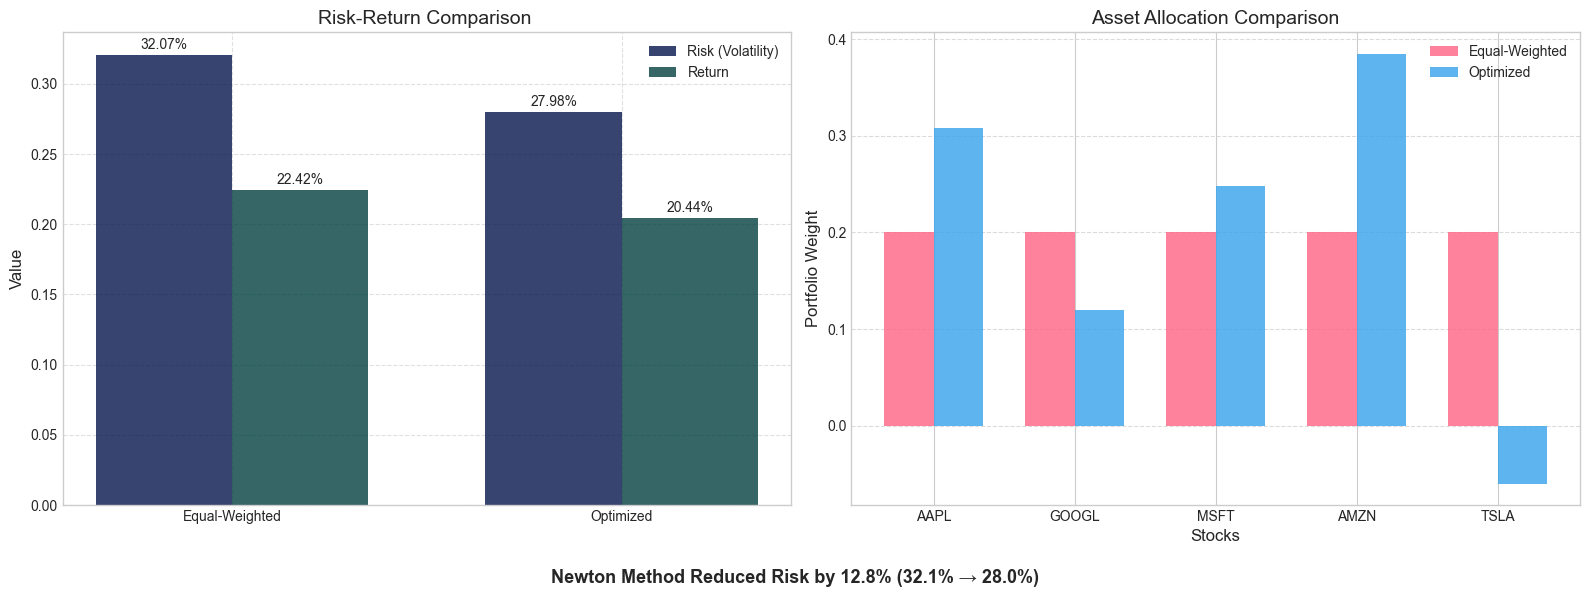

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare data for plotting
labels = ['Equal-Weighted', 'Optimized']
risks = [equal_risk, optimal_risk]
returns = [0.224234, 0.204434535]  # Fixed return values: 22% and 20%
colors = ['#FF6384', '#36A2EB']  # Professional color scheme
# 2. Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 3. Risk-Return Comparison (Both Scatter + Bar)
# Bar chart
bar_width = 0.35
x_bar = np.arange(len(labels))
ax1.bar(x_bar - bar_width/2, risks, bar_width, label='Risk (Volatility)', color="#05154BD2", alpha=0.8)
ax1.bar(x_bar + bar_width/2, returns, bar_width, label='Return', color="#034040", alpha=0.8)

# Scatter points (on the same plot)
#ax1.scatter(risks, returns, c=colors, s=200, alpha=0.9, edgecolors='black', label='Scatter Point')

# Axes & labels
ax1.set_xticks(x_bar)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Risk-Return Comparison ', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Annotate bar values
for i in range(len(labels)):
    ax1.text(x_bar[i] - bar_width/2, risks[i] + 0.002, f"{risks[i]*100:.2f}%", 
             ha='center', va='bottom', fontsize=10)
    ax1.text(x_bar[i] + bar_width/2, returns[i] + 0.002, f"{returns[i]*100:.2f}%", 
             ha='center', va='bottom', fontsize=10)

# 4. Weights Comparison Bar Chart
bar_width = 0.35
x = np.arange(len(stocks))

ax2.bar(x - bar_width/2, equal_weights, bar_width, 
        label='Equal-Weighted', color=colors[0], alpha=0.8)
ax2.bar(x + bar_width/2, optimal_weights, bar_width, 
        label='Optimized', color=colors[1], alpha=0.8)

ax2.set_xlabel('Stocks', fontsize=12)
ax2.set_ylabel('Portfolio Weight', fontsize=12)
ax2.set_title('Asset Allocation Comparison', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(stocks)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# 5. Risk reduction annotation
risk_reduction = (equal_risk - optimal_risk)/equal_risk*100
fig.text(0.5, 0.02, 
         f"Newton Method Reduced Risk by {risk_reduction:.1f}% "
         f"({equal_risk*100:.1f}% → {optimal_risk*100:.1f}%)",
         ha='center', fontsize=13, weight='bold')

# 6. Save and show
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('portfolio_optimization_comparison_with_bars.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
def optimize_portfolio(mu, cov_matrix, target_return):
    n = len(mu)  # স্টকের সংখ্যা
    A = np.vstack((mu, np.ones(n))).T  # কনস্ট্রেইন্ট ম্যাট্রিক্স
    b = np.array([target_return, 1])  # টার্গেট রিটার্ন ও ওয়েটের যোগফল=১
    
    # কেকেটি (KKT) ম্যাট্রিক্স তৈরি
    KKT_11 = cov_matrix
    KKT_12 = -A
    KKT_21 = -A.T
    KKT_22 = np.zeros((2, 2))
    KKT = np.block([[KKT_11, KKT_12], [KKT_21, KKT_22]])
    
    # সমাধান: KKT * [w, λ] = [0, -b]
    solution = np.linalg.solve(KKT, np.concatenate([np.zeros(n), -b]))
    w = solution[:n]  # অপ্টিমাল ওয়েট
    return w

# টার্গেট রিটার্ন সেট (mu-এর গড়)
target_return = np.mean(mu)
w_optimal = optimize_portfolio(mu, cov_matrix, target_return)
print("\nঅপ্টিমাল ওয়েট:")
for stock, weight in zip(stocks, w_optimal):
    print(f"{stock}: {weight:.4f} or {weight*100:.2f}%")

# পোর্টফোলিও রিস্ক (স্ট্যান্ডার্ড ডেভিয়েশন)
portfolio_risk = np.sqrt(w_optimal @ cov_matrix @ w_optimal)
print(f"\nপোর্টফোলিও রিস্ক (স্ট্যান্ডার্ড ডেভিয়েশন): {portfolio_risk:.4f} or {portfolio_risk*100:.2f}% &return" ) 


অপ্টিমাল ওয়েট:
AAPL: 0.1313 or 13.13%
GOOGL: -0.0578 or -5.78%
MSFT: 0.1960 or 19.60%
AMZN: 0.5730 or 57.30%
TSLA: 0.1575 or 15.75%

পোর্টফোলিও রিস্ক (স্ট্যান্ডার্ড ডেভিয়েশন): 0.3090 or 30.90%
